<a href="https://colab.research.google.com/github/HayateSato/DS_Practice/blob/main/BeansLeaf_Drive_PT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Understanding

- OBJECTIVES:
You work for a start-up that provides automatic detection of plant diseases by classifying images taken of leaves. Your task is to detect whether the leaf in the image suffers from Angular Leaf Spot or Bean Rust, or is healthy. Because Vision Transformers are trending right now you decide to use an implementation based on a Vision Transformer

## Background:
- Plant diseases have a significant impact on agriculture, often leading to massive crop losses if not detected and treated early. Diseases like Angular Leaf Spot and Bean Rust are common in plants like beans, and their early detection can mean the difference between a thriving crop and a ruined harvest. Manually inspecting leaves in large-scale farming is not only labor-intensive but also prone to human error.
This is where our solution comes in: automatic image classification to detect these diseases through simple photos of plant leaves.


## Data Gathering:

- Bean Leaf Dataset
```https://www.kaggle.com/datasets/prakharrastogi534/bean-leaf-dataset?resource=download-directory&select=test```

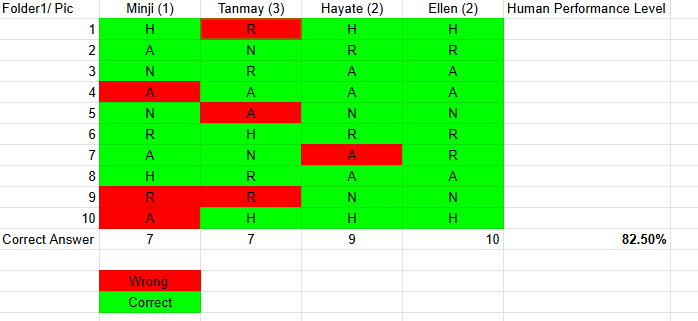

0.0 Importing libraries
==

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.8 MB/s eta 0:00:00


In [3]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from datasets import DatasetDict, Dataset, Features, ClassLabel, Image
from transformers import Trainer, TrainerCallback, ViTForImageClassification
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

1.0 Importing Data
==

In [4]:
train_path = f'/content/drive/MyDrive/Colab Notebooks/Dataset/Bean_leaf_dataset/train'
test_path = f'/content/drive/MyDrive/Colab Notebooks/Dataset/Bean_leaf_dataset/test'
val_path = f'/content/drive/MyDrive/Colab Notebooks/Dataset/Bean_leaf_dataset/validation'

# working_dir = train_path
# os.chdir(working_dir)
# os.listdir(working_dir)

In [5]:
# Set constants
BATCH_SIZE = 1
IMAGE_SIZE = 224
NUM_CLASSES = 4  # Adjust based on your dataset

# Define transformations (without data augmentation)
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to tensors
])

# Load datasets from directories
train_ds = datasets.ImageFolder(root=train_path, transform=transform)
val_ds = datasets.ImageFolder(root=val_path, transform=transform)
test_ds = datasets.ImageFolder(root=test_path, transform=transform)

def dataset_to_list(dataset):
    """
    Convert a PyTorch dataset to a list of dictionaries containing images and labels.
    """
    data = []
    for img, label in dataset:
        img = img.permute(1, 2, 0).numpy()  # Change shape to [height, width, channels]
        img = (img * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8
        data.append({
            'image': img,   # Keep as NumPy array in uint8 format
            'labels': int(label)  # Convert label to scalar
        })
    return data

# Define features for the Hugging Face dataset
features = Features({
    'image': Image(),  # Image feature from Hugging Face
    'labels': ClassLabel(num_classes=NUM_CLASSES)  # Class label feature with NUM_CLASSES
})

# Convert datasets to lists of dictionaries
train_data = dataset_to_list(train_ds)
val_data = dataset_to_list(val_ds)
test_data = dataset_to_list(test_ds)

# Create Hugging Face datasets
train_hf_ds = Dataset.from_dict({
    'image': [item['image'] for item in train_data],
    'labels': [item['labels'] for item in train_data]
}, features=features)

val_hf_ds = Dataset.from_dict({
    'image': [item['image'] for item in val_data],
    'labels': [item['labels'] for item in val_data]
}, features=features)

test_hf_ds = Dataset.from_dict({
    'image': [item['image'] for item in test_data],
    'labels': [item['labels'] for item in test_data]
}, features=features)

# Create a DatasetDict
ds = DatasetDict({
    'train': train_hf_ds,
    'validation': val_hf_ds,
    'test': test_hf_ds
})

# Display details about the DatasetDict
print(ds)


DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 1406
    })
    validation: Dataset({
        features: ['image', 'labels'],
        num_rows: 177
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 171
    })
})


**Print batch size and labels**

In [6]:
# Print class names and their corresponding indices
labels = ds['train'].features['labels']
print(labels)
print("Class names and indices:", train_ds.class_to_idx)

ClassLabel(names=['0', '1', '2', '3'], id=None)
Class names and indices: {'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2, 'no_leaf': 3}


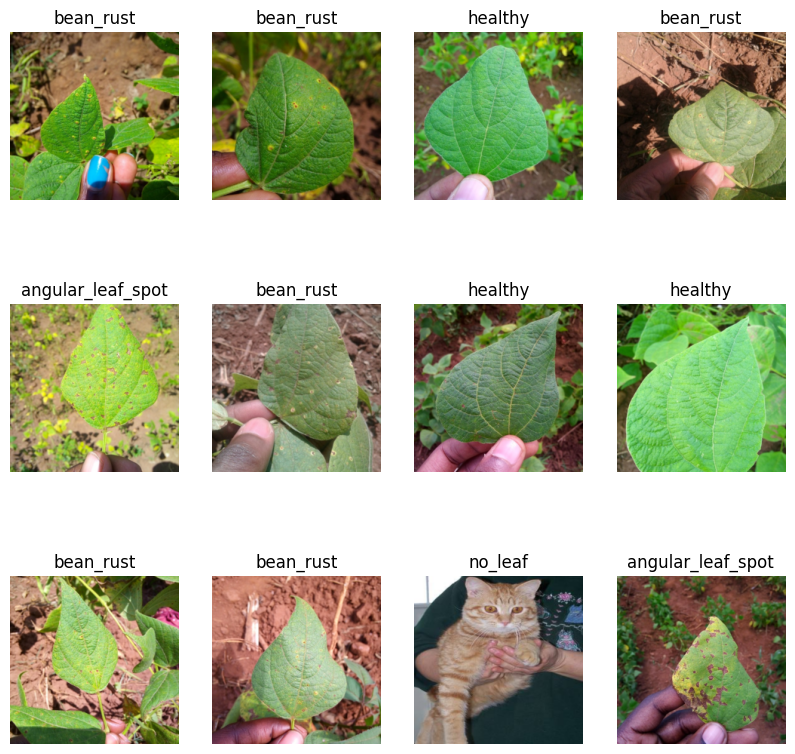

In [7]:

# Create DataLoader for the training dataset
train_loader = DataLoader(val_ds, batch_size=12, shuffle=True)  # Load 12 images for visualization

# Get class names from ImageFolder
class_names = train_ds.classes

# Plot images in a 3x4 grid
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_loader:
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        # Convert image to correct shape and scale to [0, 255]
        img = image_batch[i].permute(1, 2, 0).numpy() * 255  # Scale pixel values to [0, 255]
        plt.imshow(img.astype("uint8"))  # Convert to uint8 for display
        plt.title(class_names[labels_batch[i].item()])  # Get class name
        plt.axis("off")
    break  # Only plot one batch

plt.show()

3.0 Data Preparation
===

In [8]:
# Download Vision tranformer Beans Disease Classification Model
from transformers import ViTImageProcessor
model_name_or_path = 'nateraw/vit-base-beans'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

In [9]:
# Data Preparation with Data Argumentation


# Define augmentations
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),    # Random horizontal flip
    transforms.RandomRotation(15),        # Random rotation within 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color adjustments
])

# Transform and Argument the Dataset

def transform(example_batch):
    # Apply augmentations to each image in the batch
    augmented_images = [augmentation(x) for x in example_batch['image']]

    # Convert augmented images to pixel values
    inputs = processor(augmented_images, return_tensors='pt')

    # Include the labels in the output
    inputs['labels'] = example_batch['labels']
    return inputs

In [10]:
prepared_ds = ds.with_transform(transform)
prepared_ds

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 1406
    })
    validation: Dataset({
        features: ['image', 'labels'],
        num_rows: 177
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 171
    })
})

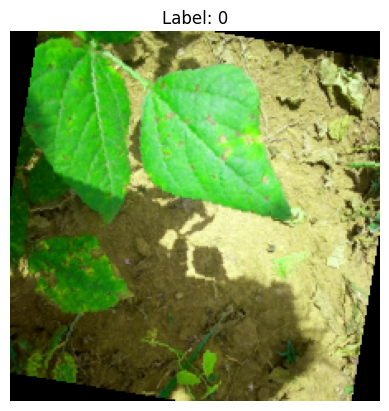

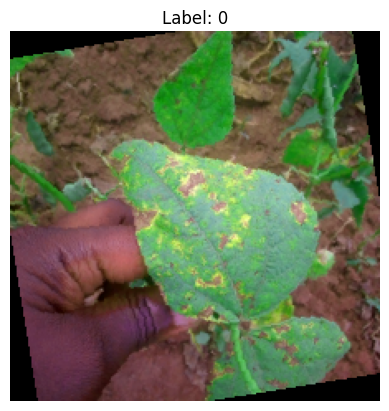

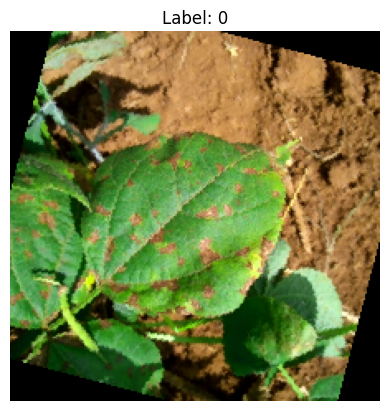

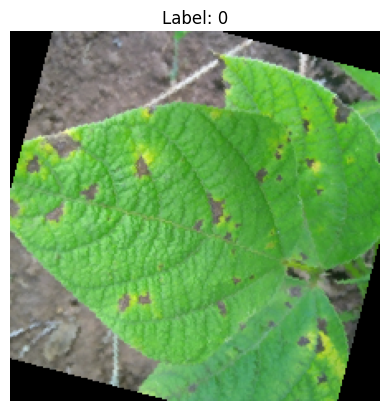

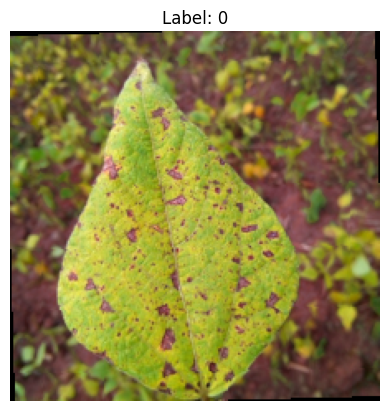

In [11]:


# Function to display a few sample images from the specified dataset split
def display_sample_images(dataset, split='train', num_samples=5):
    selected_dataset = dataset[split]
    for i in range(num_samples):
        example = selected_dataset[i]  # Get the example from the selected split

        # Access the image and label based on your dataset structure
        image = example['pixel_values']  # Use the correct key for images
        label = example['labels']  # Use the correct key for labels

        # Convert the tensor image to a numpy array and transpose dimensions for plt
        if image.ndim == 3:  # Assuming image is in shape (C, H, W)
            image = image.permute(1, 2, 0).numpy()  # Change if the dimensions are different
        elif image.ndim == 2:  # Handle grayscale images if necessary
            image = image.numpy()  # No need to permute for (H, W)

        # Rescale the image to [0, 1] for better visualization
        image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]

        # Plot the image
        plt.imshow(image)
        plt.title(f'Label: {label.item()}' if hasattr(label, 'item') else f'Label: {label}')  # Safely access label
        plt.axis('off')
        plt.show()

# Call the function to display sample images from the training set
display_sample_images(prepared_ds, split='train', num_samples=5)  # Change 'train' to 'validation' or 'test' as needed


In [12]:


def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]), # putting the dataset into batches
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [13]:


def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=1)
        accuracy = (predictions == labels).mean()

        # Replace with your loss function:
        loss = torch.nn.CrossEntropyLoss()(torch.tensor(logits), torch.tensor(labels))
        eval_loss = loss.mean().item()

        return {"accuracy": accuracy, "eval_loss": eval_loss}

In [14]:


labels = ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True  # Add this argument
)

config.json:   0%|          | 0.00/756 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at nateraw/vit-base-beans and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
for name, param in model.named_parameters():
       if "vit.encoder.layer.0" in name:  # Example: Freeze the first layer of the encoder
           param.requires_grad = True

print(model)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

for name, param in model.named_parameters():
    if "fc" not in name:  # Freeze all layers except the final fully connected layer
        param.requires_grad = False

# Print out which layers are frozen and which are not
for name, param in model.named_parameters():
    status = "Frozen" if not param.requires_grad else "Trainable"
    print(f"Layer: {name} | Status: {status}")

In [21]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-beans",
  run_name="my_bean_experiment", # Add this line!
  per_device_train_batch_size=16,
  evaluation_strategy="epoch",
  num_train_epochs=10,
  fp16=True,
  save_steps=50, # it breaks one epoch into 50 steps, in TensorFlow this is preset
  eval_steps=50,
  logging_steps=1,
  learning_rate=1e-4, # from huggingface & and some tuning
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  load_best_model_at_end=True,
  save_strategy="epoch",
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [22]:
# Initialize lists to store metrics for plotting
train_accuracy, train_loss = [], []
val_accuracy, val_loss = [], []  # Initialize as empty lists

# Define compute_metrics function for validation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    accuracy = (predictions == labels).mean()

    # Calculate validation loss using CrossEntropyLoss
    loss = torch.nn.CrossEntropyLoss()(torch.tensor(logits), torch.tensor(labels))
    eval_loss = loss.mean().item()

    # Append validation metrics for plotting
    val_accuracy.append(accuracy)
    val_loss.append(eval_loss)

    return {"accuracy": accuracy, "eval_loss": eval_loss}

# Define custom callback to live plot training metrics
class LivePlotCallback(TrainerCallback):
    def on_step_end(self, args, state, control, logs=None, **kwargs):
        # Ensure logs are not None
        if logs is not None:
            # Log training loss (if available)
            if 'loss' in logs:
                train_loss.append(logs['loss'])

            # Log training accuracy if it's in logs
            if 'accuracy' in logs:
                train_accuracy.append(logs['accuracy'])

            # Update the plot after each step
            clear_output(wait=True)
            steps = range(1, len(train_loss) + 1)

            plt.figure(figsize=(14, 5))

            # Plot Training and Validation Loss
            plt.subplot(1, 2, 1)
            plt.plot(steps, train_loss, label="Training Loss")
            if val_loss:
                plt.plot(steps, val_loss[:len(steps)], label="Validation Loss")
            plt.xlabel("Steps")
            plt.ylabel("Loss")
            plt.legend()

            # Plot Training and Validation Accuracy
            plt.subplot(1, 2, 2)
            plt.plot(steps, train_accuracy, label="Training Accuracy")
            if val_accuracy:
                plt.plot(steps, val_accuracy[:len(steps)], label="Validation Accuracy")
            plt.xlabel("Steps")
            plt.ylabel("Accuracy")
            plt.legend()

            plt.show()

# Initialize the Trainer with model, args, datasets, and metrics
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=processor,
)

# Add the custom live plotting callback to the Trainer
trainer.add_callback(LivePlotCallback())

# Start training
train_results = trainer.train()


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.169100,0.140480,0.954802
2,0.018700,0.069940,0.977401
3,0.180500,0.102640,0.983051
4,0.192000,0.072919,0.971751
5,0.017100,0.024862,0.994350
6,0.007200,0.060724,0.971751
7,0.005100,0.027959,0.994350
8,0.005100,0.064082,0.988701
9,0.005700,0.010302,0.994350
10,0.017100,0.038475,0.988701


In [18]:
print(train_results)

TrainOutput(global_step=176, training_loss=0.2405369916549799, metrics={'train_runtime': 712.4668, 'train_samples_per_second': 3.947, 'train_steps_per_second': 0.247, 'total_flos': 2.179113808677765e+17, 'train_loss': 0.2405369916549799, 'epoch': 2.0})


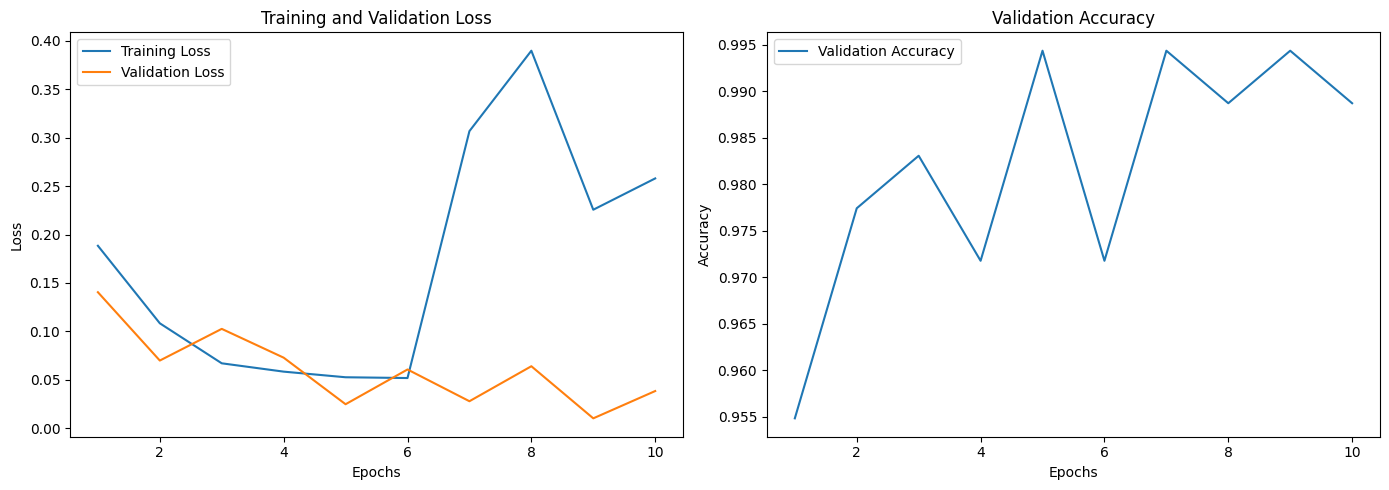

In [23]:
# Initialize lists to store accuracy and loss values
train_loss = []
val_accuracy = []
val_loss = []

# Filter epoch-level logs from trainer.state.log_history
for log in trainer.state.log_history:
    if 'loss' in log and 'epoch' in log:
        train_loss.append(log['loss'])
    if 'eval_loss' in log and 'eval_accuracy' in log:
        val_loss.append(log['eval_loss'])
        val_accuracy.append(log['eval_accuracy'])

# Plot using the available epochs for which we have both training and validation logs
epochs = range(1, len(val_loss) + 1)

# Plot Training and Validation Loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss[:len(epochs)], label="Training Loss")  # Match to length of available validation data
plt.plot(epochs, val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracy, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
trainer.save_state()

In [25]:
test_dataloader = DataLoader(prepared_ds['test'], batch_size=16)
predictions = []
labels = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation during inference
    for batch in test_dataloader:
        outputs = model(**batch)  # Get model outputs
        predicted_labels = outputs.logits.argmax(-1)  # Get predicted class labels
        predictions.extend(predicted_labels.cpu().numpy())  # Store predictions
        labels.extend(batch['labels'].cpu().numpy())  # Store true labels

cm = confusion_matrix(labels, predictions)
print(cm)

RuntimeError: Input type (float) and bias type (c10::Half) should be the same

In [26]:
class_names = train_ds.classes

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

NameError: name 'cm' is not defined

<Figure size 800x600 with 0 Axes>

In [27]:
# Print Accuracy
accuracy = accuracy_score(labels, predictions)
precision = precision_score(labels, predictions, average='weighted')  # Use weighted average for multi-class
f1 = f1_score(labels, predictions, average='weighted')  # Use weighted average for multi-class
data = {'Metric': ['Accuracy', 'Precision', 'F1 Score'],
        'Score': [accuracy, precision, f1]}
df = pd.DataFrame(data)
print(df.to_string(index=False))  # Display table without inde





/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NameError: name 'pd' is not defined

In [20]:
stop the code here

SyntaxError: invalid syntax (<ipython-input-20-c4d218dd312b>, line 1)

Distribution of Classes.
====

Goal: Check if the dataset is balanced across the three classes: Angular Leaf Spot, Bean Rust, and Healthy.

In [ ]:
# Get class names from the dataset
class_names = train_ds.classes

# Iterate through the dataset to collect labels
class_labels = []
for images, labels in train_ds:  # Unpack images and labels from the dataset
    class_labels.extend(labels.numpy())  # Convert labels to NumPy array and extend the list

# Count the occurrences of each class label
class_counts = Counter(class_labels)

# Print class distribution with class names
print("Class Distribution:")
for label, count in class_counts.items():
    print(f"Class label {label} ({class_names[label]}): {count}")

Image Data Format and Quality
===

In [ ]:
for images, _ in train_ds.take(1):  # Take one batch of images
    for img in images:
        img = np.array(img)  # Convert tensor to NumPy array
        print(f"Image shape: {img.shape}, Image dtype: {img.dtype}")
        break  # Checking just one image for format and size

# Unbatch the dataset to process individual images
train_ds_unbatched = train_ds.unbatch()

# Initialize the figure
plt.figure(figsize=(10, 10))

# Display 12 individual images
for i, (image, label) in enumerate(train_ds_unbatched.take(12)):  # take 12 images
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(image.numpy().astype("uint8"))  # Display image
    plt.title(class_names[label])  # Display label using class names
    plt.axis("off")  # Remove axes

plt.show()


Any Missing, Corrupted, or Duplicate Images?
====

In [ ]:
# Checking for corrupted images
# # !pip install tensorflow

# import tensorflow as tf
# from PIL import Image

corrupted_images = []
# Iterate through the dataset, accessing individual image paths
for images, labels in train_ds:
    for img_tensor in images:
        try:
            # Convert the tensor to a NumPy array
            img_array = img_tensor.numpy()
            # Create a PIL Image from the NumPy array
            img = Image.fromarray(img_array.astype('uint8'))
            img.verify()  # Verify if the image is valid
        except (IOError, SyntaxError) as e:
            print(f"Corrupted Image: {img_tensor}")
            corrupted_images.append(img_tensor)


print(f"the number of corrupted Images: {len(corrupted_images)}")

In [ ]:
#duplicate images
# import hashlib
# import os

def file_hash(filepath):
    """Calculate the hash of a file."""
    with open(filepath, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

image_hashes = {}
duplicates = []
for img_name in os.listdir(train_path):
    img_path = os.path.join(train_path, img_name)
    # Check if the item is a file before calculating the hash
    if os.path.isfile(img_path):
        img_hash = file_hash(img_path)
        if img_hash in image_hashes:
            duplicates.append(img_name)
        else:
            image_hashes[img_hash] = img_name

print(f"the number of duplicate Images: {len(duplicates)}")

Data Augmentation
===

In [ ]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers

# Data Argumentation
resize_and_rescale = keras.Sequential([
    layers.Resizing(224, 224),
    layers.Rescaling(1./255)
])

# Image augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(factor=0.1),  # Adjust brightness by a factor (0.0 - 1.0)
    layers.RandomContrast(factor=0.1),    # Adjust contrast by a factor (0.0 - 1.0)
    layers.RandomSaturation(factor=0.1)
    ######## add lighting / saturation of the image samples ##########
])

In [ ]:
# Data enhancement
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Unbatch the dataset to get individual images
unbatched_ds = train_ds.unbatch()

# Take one image and its label
for image, label in unbatched_ds.take(4):
    # Apply resizing and rescaling
    resized_image = resize_and_rescale(image)

    # Apply augmentation
    augmented_image = data_augmentation(resized_image)

    # Convert both images from float32 [0,1] to uint8 [0,255] for display
    resized_image = tf.clip_by_value(resized_image * 255, 0, 255)
    resized_image = tf.cast(resized_image, tf.uint8)

    augmented_image = tf.clip_by_value(augmented_image * 255, 0, 255)
    augmented_image = tf.cast(augmented_image, tf.uint8)

    # Plot both images side by side
    plt.figure(figsize=(10, 5))

    # Show resized image
    plt.subplot(1, 2, 1)
    plt.imshow(resized_image.numpy())
    plt.title("Resized and Rescaled Image")
    plt.axis("off")

    # Show augmented image
    plt.subplot(1, 2, 2)
    plt.imshow(augmented_image.numpy())
    plt.title("Augmented Image")
    plt.axis("off")

    plt.show()

In [ ]:
### Epoch should be less than 10max (possibily 20 with this dataset unless the loss is reudced)
### or tweak the lr

2.0

In [ ]:

# Set constants
BATCH_SIZE = 1
IMAGE_SIZE = 224
NUM_CLASSES = 4  # Adjust based on your dataset

# Define transformations (without data augmentation)
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to tensors
])

# Load datasets from directories
train_ds = datasets.ImageFolder(root="train_path", transform=transform)
val_ds = datasets.ImageFolder(root="val_path", transform=transform)
test_ds = datasets.ImageFolder(root="test_path", transform=transform)

def dataset_to_list(dataset):
    """
    Convert a PyTorch dataset to a list of dictionaries containing images and labels.
    """
    data = []
    for img, label in dataset:
        img = img.permute(1, 2, 0).numpy()  # Change shape to [height, width, channels]
        img = (img * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8
        data.append({
            'image': img,   # Keep as NumPy array in uint8 format
            'labels': int(label)  # Convert label to scalar
        })
    return data

# Define features for the Hugging Face dataset
features = Features({
    'image': Image(),  # Image feature from Hugging Face
    'labels': ClassLabel(num_classes=NUM_CLASSES)  # Class label feature with NUM_CLASSES
})

# Convert datasets to lists of dictionaries
train_data = dataset_to_list(train_ds)
val_data = dataset_to_list(val_ds)
test_data = dataset_to_list(test_ds)

# Create Hugging Face datasets
train_hf_ds = Dataset.from_dict({
    'image': [item['image'] for item in train_data],
    'labels': [item['labels'] for item in train_data]
}, features=features)

val_hf_ds = Dataset.from_dict({
    'image': [item['image'] for item in val_data],
    'labels': [item['labels'] for item in val_data]
}, features=features)

test_hf_ds = Dataset.from_dict({
    'image': [item['image'] for item in test_data],
    'labels': [item['labels'] for item in test_data]
}, features=features)

# Create a DatasetDict
ds = DatasetDict({
    'train': train_hf_ds,
    'validation': val_hf_ds,
    'test': test_hf_ds
})

# Display details about the DatasetDict
print(ds)
